In [1]:
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample')

import torch
from torch import nn
from laplace import Laplace
import copy
from tqdm import tqdm
torch.manual_seed(1) 
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from src.weight_distribution.Full import FullCovariance
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
import matplotlib
from src.network.feature_extractor import FC_Net
from src.network.Classification import LLVIClassification
from src.network import LikApprox, PredictApprox
from datasets.Classification.TwoMoons import create_test_points, create_train_set
from datetime import datetime

In [2]:
n_datapoints=1024
batch_size = 32
x, y = create_train_set(n_datapoints=n_datapoints, noise=0.2)
train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size)

In [3]:
# data saver
mc_train_losses = []
mc_train_times = []
samples_list = [1,10]
torch.manual_seed(1);
lr = 1e-3

In [4]:
class FC_Net_Laplace(nn.Module):
    def __init__(self, out_dim, weight_decay):
        super().__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, out_dim, bias=False)
        self.nll = nn.LeakyReLU() # dont use normal relu here since otherwise some values can be 0 later
        self.optimizer = torch.optim.Adam(self.parameters(), weight_decay=weight_decay, lr=1e-3)
        self.weight_decay = weight_decay

    def forward(self, x):
        h1 = self.nll(self.fc1(x))
        h2 = self.nll(self.fc2(h1))
        h3 = self.fc3(h2)
        return h3

    def delete_last_layer(self):
        self.forward = self.new_forward
        self.optimizer = torch.optim.Adam(self.parameters(), weight_decay=self.weight_decay, lr=1e-4)

    def new_forward(self, x):
        h1 = self.nll(self.fc1(x))
        h2 = self.nll(self.fc2(h1))
        return h2
# init model
torch.manual_seed(3)
weight_decay = 5e-4
laplace_model = FC_Net_Laplace(2, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

# train
epochs = 200
pbar = tqdm(range(epochs))
for i in pbar:
    for X_batch, y_batch in train_loader:
        laplace_model.optimizer.zero_grad()
        loss = criterion(laplace_model(X_batch), y_batch)
        loss.backward()
        laplace_model.optimizer.step()
        pbar.set_description(f"Loss: {round(loss.item(), 2)}")

# define laplace
la = Laplace(laplace_model, "classification",
    subset_of_weights="last_layer", hessian_structure="full",
    prior_precision=5e-4) # prior precision is set to wdecay
la.fit(train_loader)



# define weight distribution and update values
from src.weight_distribution.Full import FullCovariance
dist_lp_init = FullCovariance(20, 2, lr=1e-4)
dist_lp_init.update_cov(la.posterior_covariance)
dist_lp_init.update_mean(torch.t(laplace_model.fc3.weight))


# delete last layer
laplace_model.delete_last_layer()


Loss: 0.15:  84%|████████▎ | 167/200 [00:05<00:01, 31.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 0.02: 100%|██████████| 200/200 [00:06<00:00, 31.12it/s]


In [5]:
use_laplace_init=True

In [6]:

# go over all mc methods
for samples in samples_list:
    print("Starting run", samples)
    if use_laplace_init:
        feature_extractor_mc = copy.deepcopy(laplace_model)
        dist = copy.deepcopy(dist_lp_init)
    else:
        feature_extractor_mc = FC_Net(layers=[2, 20, 20],lr=lr, weight_decay=5e-4, optimizer=torch.optim.Adam, nll=torch.nn.LeakyReLU())
        dist = FullCovariance(20, 2, lr=lr, init_log_var=0)
    net_mc = LLVIClassification(20, 2, feature_extractor_mc, dist,
    prior_log_var=-7, optimizer_type=torch.optim.Adam,
    tau=1, lr=lr)
    start_time = datetime.now()
    train_loss = net_mc.train_model(train_loader, epochs=500, n_datapoints=n_datapoints, samples=samples, method=LikApprox.MONTECARLO)
    # train_loss = net_mc.train_em_style(train_loader, n_datapoints, total_epochs=100, inner_epochs_fe=1, inner_epochs_vi=3, method=LikApprox.MONTECARLO, samples=samples)
    total_time = int((datetime.now() - start_time).total_seconds())
    mc_train_losses.append(train_loss)
    mc_train_times.append(total_time)

Starting run 1


RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

In [ ]:
approx_list = ["jennsen", "bohning", "multidelta"]
cf_train_losses = []
cf_train_times = []
for approx_name in approx_list:
    print("Starting approx", approx_name)
    if use_laplace_init:
        feature_extractor_cf = copy.deepcopy(laplace_model)
        dist = copy.deepcopy(dist_lp_init)
    else:
        feature_extractor_cf = FC_Net(layers=[2, 20, 20],lr=lr, weight_decay=5e-4, optimizer=torch.optim.Adam, nll=torch.nn.LeakyReLU())
        dist = FullCovariance(20, 2, lr=lr, init_log_var=0)
    net_cf = LLVIClassification(20, 2, feature_extractor_cf, dist,
    prior_log_var=-7, optimizer_type=torch.optim.Adam,
    tau=1, lr=lr)
    start_time = datetime.now()
    train_loss = net_cf.train_model(train_loader, epochs=500, n_datapoints=n_datapoints, samples=5, method=LikApprox.CLOSEDFORM, approx_name=approx_name)
    # train_loss = net_cf.train_em_style(train_loader, n_datapoints, total_epochs=100, inner_epochs_fe=1, inner_epochs_vi=3, method=LikApprox.CLOSEDFORM, approx_name=approx_name)
    cf_train_losses.append(train_loss)
    cf_train_times.append(int((datetime.now() - start_time).total_seconds()))

Starting approx jennsen


prediction_loss:0.16 kl_loss:0.57: 100%|██████████| 500/500 [00:23<00:00, 20.83it/s]


Starting approx bohning


prediction_loss:0.14 kl_loss:0.54: 100%|██████████| 500/500 [00:27<00:00, 18.28it/s]


Starting approx multidelta


prediction_loss:0.31 kl_loss:0.55: 100%|██████████| 500/500 [00:25<00:00, 19.27it/s]


Text(0, 0.5, 'Loss')

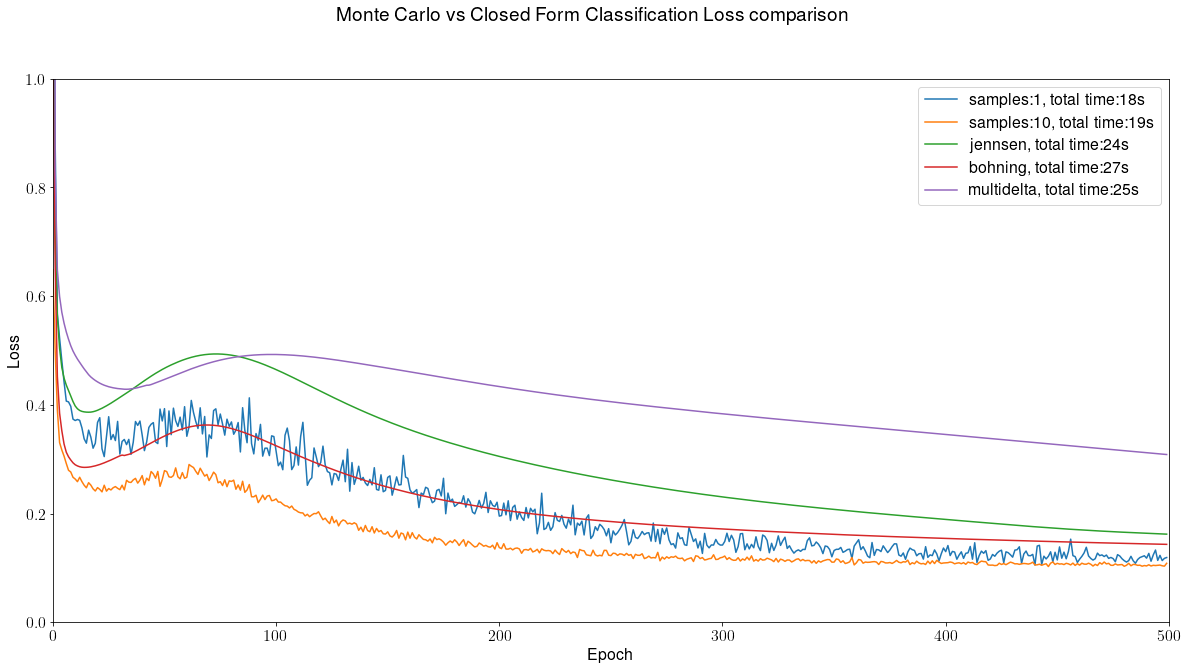

In [ ]:
# visualization
fig, ax = plt.subplots(figsize=(20,10))
vi_train_epochs=500
for samples, train_loss, train_time in zip(samples_list, mc_train_losses, mc_train_times):
    ax.plot(list(range(vi_train_epochs)), (train_loss["prediction_loss"]), label=f"samples:{samples}, total time:{train_time}s")

for approx_name, train_loss, train_time in zip(approx_list, cf_train_losses, cf_train_times):
    ax.plot(list(range(vi_train_epochs)), (train_loss["prediction_loss"]), label=f"{approx_name}, total time:{train_time}s") 

ax.legend()
ax.set_ylim(0, 1)
ax.set_xlim(0, 500)
fig.suptitle("Monte Carlo vs Closed Form Classification Loss comparison")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")